In [1]:
import pandas as pd
import numpy as np
import re
import os
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from patsy.contrasts import Treatment
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
"""
Define I/O info
"""
# path to input directory
inDIR = 'C:/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/data/'
# file name of gridded path intensity data (output from gps_to_gridded_path_intensity.ipynb)
griddata_f = '2017_grazing_time_gridded_all_extracted.csv'

# path to output directory
outDIR = 'C:/Users/sean.kearney/OneDrive - USDA/Documents/Projects/GPS_v_hetgen/models/'

if not os.path.exists(outDIR):
    os.mkdir(outDIR)

In [3]:
"""
Load data and check data types
"""
df_wkly_grid_full = pd.read_csv(os.path.join(inDIR, griddata_f))
display(df_wkly_grid_full.dtypes)

index_id          int64
mod_data         object
week              int64
Pasture          object
Steer_ID         object
UTM_X           float64
UTM_Y           float64
grazing_secs    float64
TPC             float64
dFence          float64
dTank           float64
PC_dmt           object
PC_pct          float64
PC_div          float64
Biomass         float64
CP              float64
DOM             float64
TPC_c            object
dCorner         float64
dtype: object

In [4]:
"""
Add season to dataset based on week
"""

def season_func(wk):
    if wk <= 26:
        return 'early'
    elif wk <= 32:
        return 'mid'
    elif wk >= 33:
        return 'late'

df_wkly_grid_full['season'] = df_wkly_grid_full['week'].apply(lambda x: season_func(x))
df_wkly_grid_full['season'] = pd.Categorical(df_wkly_grid_full['season'], ['early', 'mid', 'late'])

'Number of grazing values > 10,000 = 6'

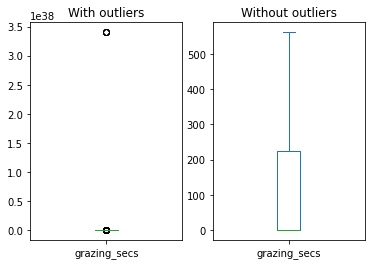

In [5]:
"""
Check grazing intensity values for further cleaning
"""
max_graze_secs = 10000
fig, axs = plt.subplots(nrows=1, ncols=2)
df_wkly_grid_full['grazing_secs'].plot.box(showfliers=True, ax=axs[0], title='With outliers')
df_wkly_grid_full['grazing_secs'].plot.box(showfliers=False, ax=axs[1], title='Without outliers')
display('Number of grazing values > ' + "{:,}".format(max_graze_secs) + ' = ' + "{:,}".format(
    len(df_wkly_grid_full[df_wkly_grid_full['grazing_secs'] > 10000])))

In [6]:
# mask grid cells with seemingly erroneous grazing intensity
df_wkly_grid_full.loc[df_wkly_grid_full['grazing_secs'] > max_graze_secs, 'grazing_secs'] = np.nan

In [7]:
"""
Remove data in corners and near water tanks
"""
df_wkly_grid_full = df_wkly_grid_full[df_wkly_grid_full['dTank'] > 60]
df_wkly_grid_full = df_wkly_grid_full[df_wkly_grid_full['dCorner'] > 60]

In [8]:
"""
Flag and remove any outliers beyond last 60-sec bin with only one pixel
"""

def flag_graze_outliers(x, bins=np.arange(-5, 10000, 60)):
    groups = x.groupby(pd.cut(x, bins, include_lowest=False))
    one_bins = bins[:-1][(groups.count() == 1).values] 
    gt_one_bins = bins[:-1][(groups.count() > 1).values] 
    last_one_bin = np.min([np.max(gt_one_bins) + 60, np.max([np.min(one_bins), np.max(gt_one_bins)])])
    return (x >= last_one_bin).astype('int')
    
df_wkly_grid_full['grazing_secs_outlier'] = df_wkly_grid_full.groupby(['week', 'Pasture', 'Steer_ID'])['grazing_secs'].transform(flag_graze_outliers)
print('Stats of grid cells removed across all steer-weeks:')
display(df_wkly_grid_full.groupby(['week', 'Pasture', 'Steer_ID'])['grazing_secs_outlier'].sum().describe())

Stats of grid cells removed across all steer-weeks:


count    198.000000
mean       6.171717
std        2.908208
min        2.000000
25%        4.000000
50%        6.000000
75%        8.000000
max       19.000000
Name: grazing_secs_outlier, dtype: float64

In [9]:
# remove grazing outliers
df_wkly_grid_full = df_wkly_grid_full[df_wkly_grid_full['grazing_secs_outlier'] == 0]

In [10]:
"""
Calculate weekly grazing minutes per grid cell to account for missing data
"""
# get the sum total of grazing seconds for each steer-week
df_wkly_grid_full['grazing_wkly_sum'] = df_wkly_grid_full.groupby(['Pasture', 'Steer_ID', 'week'])['grazing_secs'].transform('sum')
# get the proportion of the weekly total for each grid cell
df_wkly_grid_full['grazing_wkly_prop'] = df_wkly_grid_full['grazing_secs'] / df_wkly_grid_full['grazing_wkly_sum']
# calculate grazing minutes based on the proportion of a full week
df_wkly_grid_full['grazing_wkly_mins'] = df_wkly_grid_full['grazing_wkly_prop'] * (60*24*7)

In [11]:
"""
Calculate the average weekly values for each grid cell to account for uneven steer sample sizes
"""
# get weekly averages of continuous variables
df_wkly_grid_avg = df_wkly_grid_full.groupby(
    ['UTM_X', 'UTM_Y', 'Pasture', 'week']).mean().reset_index(drop=False)
# get first value of static variables that do not change by week
df_wkly_grid_avg[['season', 'mod_data', 'PC_dmt', 'TPC_c']] = df_wkly_grid_full.groupby(
    ['UTM_X', 'UTM_Y', 'Pasture', 'week']).first().reset_index(drop=False)[['season', 'mod_data', 'PC_dmt', 'TPC_c']]

In [12]:
"""
Organize dataset into training and testing data
"""
df_wkly_grid_test = df_wkly_grid_avg[df_wkly_grid_avg['mod_data'] == 'test']
df_wkly_grid = df_wkly_grid_avg[df_wkly_grid_avg['mod_data'] == 'train']

In [13]:
"""
Check for very rare plant community classes by pasture
"""
pc_dmt_summary = df_wkly_grid.groupby(['Pasture', 'week'])['PC_dmt'].value_counts().groupby(
    ['Pasture', 'PC_dmt']).max().rename('value').to_frame().reset_index().pivot(index='PC_dmt', columns='Pasture')['value']
pc_dmt_summary['Total'] = pc_dmt_summary.sum(axis=1)
display(pc_dmt_summary)

Pasture,15E,17N,20SE,26E,31E,7NW,Total
PC_dmt,,,,,,,
Bare_veg,4.0,1.0,27.0,4.0,20.0,3.0,59.0
C3,NaN,27.0,475.0,3.0,13.0,1.0,519.0
C3_C4_mix,371.0,535.0,339.0,92.0,734.0,946.0,3017.0
C4,1061.0,373.0,243.0,1265.0,844.0,357.0,4143.0
Saltgrass,NaN,440.0,318.0,NaN,5.0,72.0,835.0
Shrub,NaN,2.0,14.0,NaN,NaN,11.0,27.0
UNK,NaN,10.0,9.0,17.0,11.0,2.0,49.0


In [14]:
"""
Check for very rare topographic position classes by pasture
"""
tpc_dmt_summary = df_wkly_grid.groupby(['Pasture', 'week'])['TPC_c'].value_counts().groupby(
    ['Pasture', 'TPC_c']).max().rename('value').to_frame().reset_index().pivot(index='TPC_c', columns='Pasture')['value']
tpc_dmt_summary['Total'] = tpc_dmt_summary.sum(axis=1)
display(tpc_dmt_summary)

Pasture,15E,17N,20SE,26E,31E,7NW,Total
TPC_c,,,,,,,
Flat Plains,346.0,171.0,658.0,841.0,154.0,951.0,3121.0
Highlands,291.0,289.0,44.0,102.0,483.0,77.0,1286.0
Lowlands,346.0,641.0,450.0,170.0,426.0,183.0,2216.0
Open Slopes,448.0,258.0,273.0,269.0,547.0,181.0,1976.0
Other,5.0,29.0,NaN,1.0,17.0,NaN,52.0


In [15]:
"""
Drop rare classes
"""
df_wkly_grid = df_wkly_grid[~df_wkly_grid['PC_dmt'].isin(['Bare', 'Bare_veg', 'UNK', 'Shrub'])]
df_wkly_grid = df_wkly_grid[~df_wkly_grid['TPC_c'].isin(['Other'])]

# print final class numbers
print(df_wkly_grid['TPC_c'].value_counts())
print('\n')
print(df_wkly_grid['PC_dmt'].value_counts())

Flat Plains    24720
Lowlands       17054
Open Slopes    15582
Highlands      10214
Name: TPC_c, dtype: int64


C4           32937
C3_C4_mix    23889
Saltgrass     6608
C3            4136
Name: PC_dmt, dtype: int64


In [16]:
min_class_n = 10
aicw_func = lambda x: np.exp(-0.5 * (x - x.min())) / np.sum(np.exp(-0.5 * (x - x.min())))
aicd_func = lambda x: x - x.min()

m0 = 'grazing_wkly_mins ~ dFence + dTank'
m1 = m0 + ' + C(TPC_c, Treatment(reference="Flat Plains"))'
m2a = m0 + ' + Biomass'
m2b = m0 + ' + Biomass + I(Biomass**2)'
m2c = m0 + ' + CP'
m2d = m2a + ' + CP' 
m2e = m2a + ' + CP + Biomass:CP'
m2f = m2b + ' + CP'
m2g = m2b + ' + CP + Biomass:CP'
m3a = m0 + ' + C(PC_dmt, Treatment(reference="C3_C4_mix"))'
m3b = m0 + ' + PC_div'
m3c = m0 + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")) + PC_div'
m3d = m0 + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")) * PC_div'

model_dict = {
    'M0': m0,
    'M1': m1,
    'M2a': m2a,
    'M2b': m2b,
    'M2c': m2c,
    'M2d': m2d,
    'M2e': m2e,
    'M2f': m2f,
    'M2g': m2g,
    'M3a': m3a,
    'M3b': m3b,
    'M3c': m3c,
    'M3d': m3d
}

In [17]:
"""
Run the initial candidate models
"""
df_results = pd.DataFrame(columns=['week', 'Pasture', 'model', 'formula', 'AIC'])
idx = 0
for group in tqdm(df_wkly_grid.groupby(['week', 'Pasture'])):
    # drop NANs
    data = group[1].dropna(axis=0, how='any')
    
    # remove any locations related to a class with fewer than N observations
    data = data[~data['PC_dmt'].isin(
        data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < min_class_n])]
    data = data[~data['TPC_c'].isin(
        data['TPC_c'].value_counts().index[data['TPC_c'].value_counts() < min_class_n])]
       
    df_results_tmp = pd.DataFrame(columns=['week', 'Pasture', 'model', 'formula', 'AIC'])
    
    # run initial models for negative binomial
    for i in model_dict:
        form = model_dict[i]
        #print('NB: ' + form)
        try:
            md_tmp = smf.glm(form, data, family=sm.families.NegativeBinomial(),
                             offset=np.log(data['grazing_wkly_sum']/60.0))
            mdf_tmp = md_tmp.fit()
            aic_tmp = round(mdf_tmp.aic, 2)
        except (ValueError, np.linalg.LinAlgError):
            aic_tmp = np.nan
        df_tmp = pd.DataFrame({
            'week': group[0][0],
            'season': season_func(group[0][0]),
            'Pasture': group[0][1],
            'model': i,
            'formula': form,
            'AIC': aic_tmp
        }, index=[idx])
        df_results_tmp = df_results_tmp.append(df_tmp)
        idx += 1
        
    df_results = df_results.append(df_results_tmp)
df_results['season'] = pd.Categorical(df_results['season'], ['early', 'mid', 'late'])

  0%|          | 0/48 [00:00<?, ?it/s]

In [46]:
"""
Analyze the top forage condition models
"""
# calculate AIC weights for the forage condition models
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2'])), 
               'AICw_FC'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2']))].groupby(['week', 'Pasture'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2'])), 
               'AICd_FC'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2']))].groupby(['week', 'Pasture'])['AIC'].transform(
    aicd_func)
df_results['top_model_FC'] = df_results.groupby(['week', 'Pasture'])['AICw_FC'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_FC'] = df_results.groupby(['week', 'Pasture'])['AICd_FC'].transform(
    lambda x: [int(i) for i in x <= 2.0])

# print the results by season
display(df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2']))].groupby(['season', 'model'])[['top_model_FC', 'candidate_model_FC', 'AICw_FC', 'AICd_FC']].aggregate(
    func={'AICd_FC': [np.median, np.std], 'AICw_FC': [np.mean, np.std], 
          'top_model_FC': np.sum, 'candidate_model_FC': np.sum}, axis=1).sort_values(['season', ('AICd_FC', 'median')]))
display(df_results.loc[df_results['model'].str.contains(
    '|'.join(['M2']))].groupby(['model'])[['top_model_FC', 'candidate_model_FC', 'AICw_FC', 'AICd_FC']].aggregate(
    func={'AICd_FC': [np.median, np.std], 'AICw_FC': [np.mean, np.std], 
          'top_model_FC': np.sum, 'candidate_model_FC': np.sum}, axis=1).sort_values(('AICd_FC', 'median')))

AICd_FC                   AICw_FC               top_model_FC  \
                median         std          mean           std          sum   
season model                                                                  
early  M2_tpc    0.000    0.000000  4.999901e-01  3.842137e-05           36   
       M2g      71.245   36.722222  1.887246e-05  7.672622e-05            0   
       M2f      85.830   37.956485  4.271752e-07  1.798102e-06            0   
       M2e      90.460   41.947678  3.834826e-07  1.220788e-06            0   
       M2d      99.265   65.071372  1.465026e-08  4.289315e-08            0   
       M2b     124.995   51.784894  5.325680e-10  1.802891e-09            0   
       M2c     142.805   97.364036  1.230313e-08  5.082639e-08            0   
       M2a     152.255   68.797642  1.457704e-11  4.779466e-11            0   
mid    M2_tpc    0.000    0.945504  4.691736e-01  1.000638e-01           34   
       M2g      30.695   74.169332  2.207564e-02  6.361101e-02            0   
       M2f      57.375   87.021376  4.988601e-03  1.868338e-02            0   
       M2e      59.530   81.770477  3.405915e-02  1.428288e-01            1   
       M2d      78.800   86.407286  2.845653e-04  1.139301e-03            0   
       M2b     193.390  122.513442  2.447779e-04  8.775721e-04            0   
       M2a     210.445  124.217270  5.512273e-13  2.325222e-12            0   
       M2c     240.305  134.069813  5.746532e-12  2.170506e-11            0   
late   M2_tpc    0.000    0.590069  4.647391e-01  9.993846e-02           22   
       M2g      28.985   55.795736  3.852180e-02  1.159390e-01            1   
       M2f      42.840   55.270496  2.147338e-03  4.513828e-03            0   
       M2e      57.110   58.465082  2.119415e-02  7.201852e-02            0   
       M2d      70.045   59.066152  1.599756e-03  3.737839e-03            0   
       M2b      78.150   55.864367  4.698983e-03  1.187354e-02            0   
       M2a     106.085   55.955605  2.018321e-03  6.981588e-03            0   
       M2c     108.050  164.929013  3.415534e-04  1.170637e-03            0   

              candidate_model_FC  
                             sum  
season model                      
early  M2_tpc                 36  
       M2g                     0  
       M2f                     0  
       M2e                     0  
       M2d                     0  
       M2b                     0  
       M2c                     0  
       M2a                     0  
mid    M2_tpc                 34  
       M2g                     2  
       M2f                     0  
       M2e                     1  
       M2d                     0  
       M2b                     0  
       M2a                     0  
       M2c                     0  
late   M2_tpc                 22  
       M2g                     1  
       M2f                     0  
       M2e                     1  
       M2d                     0  
       M2b                     0  
       M2a                     0  
       M2c                     0

AICd_FC               AICw_FC           top_model_FC  \
         median         std      mean       std          sum   
model                                                          
M2_tpc    0.000    0.651193  0.479621  0.079759           92   
M2g      49.835   57.708838  0.017916  0.069622            1   
M2f      64.085   64.562736  0.002408  0.011654            0   
M2e      72.040   62.993498  0.018071  0.093905            1   
M2d      91.100   72.186226  0.000507  0.002040            0   
M2b     113.535   96.796717  0.001267  0.006107            0   
M2a     128.895  101.646711  0.000505  0.003491            0   
M2c     159.215  131.543386  0.000085  0.000586            0   

       candidate_model_FC  
                      sum  
model                      
M2_tpc                 92  
M2g                     3  
M2f                     0  
M2e                     2  
M2d                     0  
M2b                     0  
M2a                     0  
M2c                     0

In [45]:
"""
Analyze the top plant community models
"""
# calculate AIC weights and delta for the plant community models
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3'])), 
               'AICw_PC'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3']))].groupby(['week', 'Pasture'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3'])), 
               'AICd_PC'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3']))].groupby(['week', 'Pasture'])['AIC'].transform(
    aicd_func)
df_results['top_model_PC'] = df_results.groupby(['week', 'Pasture'])['AICw_PC'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_PC'] = df_results.groupby(['week', 'Pasture'])['AICd_PC'].transform(
    lambda x: [int(i) for i in x <= 2.0])

# print the results by season
display(df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3']))].groupby(['season', 'model'])[['top_model_PC', 'candidate_model_PC', 'AICw_PC', 'AICd_PC']].aggregate(
    func={'AICd_PC': [np.median, np.std], 'AICw_PC': [np.mean, np.std],
          'top_model_PC': np.sum, 'candidate_model_PC': np.sum}, axis=1).sort_values(['season', ('AICd_PC', 'median')]))
display(df_results.loc[df_results['model'].str.contains(
    '|'.join(['M3']))].groupby(['model'])[['top_model_PC', 'candidate_model_PC', 'AICw_PC', 'AICd_PC']].aggregate(
    func={'AICd_PC': [np.median, np.std], 'AICw_PC': [np.mean, np.std], 
          'top_model_PC': np.sum, 'candidate_model_PC': np.sum}, axis=1).sort_values(('AICd_PC', 'median')))

AICd_PC                   AICw_PC               top_model_PC  \
                median         std          mean           std          sum   
season model                                                                  
early  M3_tpc    0.000    0.000000  4.999713e-01  1.188588e-04           36   
       M3d      63.085   36.883518  5.740154e-05  2.412034e-04            0   
       M3c      89.170   45.565070  1.435174e-08  4.315347e-08            0   
       M3b     129.185   64.895002  1.910161e-08  8.103837e-08            0   
       M3a     158.510   83.697673  3.463179e-08  1.049998e-07            0   
mid    M3_tpc    0.000    0.116155  4.809403e-01  4.840994e-02           34   
       M3d      62.920   97.687385  3.674996e-02  9.852547e-02            1   
       M3c      99.780   95.764360  3.162941e-04  1.284342e-03            0   
       M3a     114.945   89.605530  7.882146e-04  3.344095e-03            0   
       M3b     171.965   96.348162  2.650123e-04  1.124340e-03            0   
late   M3_tpc    0.000    0.000000  4.993330e-01  1.395568e-03           24   
       M3d      50.050   33.487093  1.311547e-03  2.856492e-03            0   
       M3c      55.090   44.492252  8.087961e-06  1.779515e-05            0   
       M3a      90.845  114.897092  1.424392e-05  2.878185e-05            0   
       M3b     104.155  107.752749  3.720170e-08  1.213687e-07            0   

              candidate_model_PC  
                             sum  
season model                      
early  M3_tpc                 36  
       M3d                     0  
       M3c                     0  
       M3b                     0  
       M3a                     0  
mid    M3_tpc                 36  
       M3d                     1  
       M3c                     0  
       M3a                     0  
       M3b                     0  
late   M3_tpc                 24  
       M3d                     0  
       M3c                     0  
       M3a                     0  
       M3b                     0

AICd_PC              AICw_PC           top_model_PC candidate_model_PC
         median        std      mean       std          sum                sum
model                                                                         
M3_tpc    0.000   0.071788  0.492675  0.030780           94                 96
M3d      55.270  68.064268  0.014131  0.061861            1                  1
M3c      85.660  69.751197  0.000121  0.000788            0                  0
M3a     110.975  94.110407  0.000299  0.002047            0                  0
M3b     133.330  88.000612  0.000099  0.000689            0                  0

In [20]:
"""
Define the top vegetation models
"""
m2_top = m2g
m3_top = m3d

m4a = m2_top + re.sub(re.escape(m0), '', m3_top)
m4b = m4a + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")):Biomass'
m4c = m4a + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")):CP'
m4d = m4a + ' + PC_div:Biomass'
m4e = m4a + ' + PC_div:CP'
m4f = m4b + ' + C(PC_dmt, Treatment(reference="C3_C4_mix")):CP'
m4g = m4d + ' + PC_div:CP'
m4h = m4b + ' + PC_div:Biomass + C(PC_dmt, Treatment(reference="C3_C4_mix")):CP + PC_div:CP'

model_dict_veg = {
    'M4a': m4a,
    'M4b': m4b,
    'M4c': m4c,
    'M4d': m4d,
    'M4e': m4e,
    'M4f': m4f,
    'M4g': m4g,
    'M4h': m4h
}

In [21]:
"""
Run additional vegetation models
"""
for group in tqdm(df_wkly_grid.groupby(['week', 'Pasture'])):
    # drop NANs
    data = group[1].dropna(axis=0, how='any')

    # remove any locations related to a class with fewer than N observations
    data = data[~data['PC_dmt'].isin(
        data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < min_class_n])]
    data = data[~data['TPC_c'].isin(
        data['TPC_c'].value_counts().index[data['TPC_c'].value_counts() < min_class_n])]
       
    df_results_tmp = pd.DataFrame(columns=['week', 'Pasture', 'model', 'formula', 'AIC'])
    
    # run forage condition models for negative binomial
    for i in model_dict_veg:
        form = model_dict_veg[i]
        #print('NB: ' + form)
        try:
            md_tmp = smf.glm(form, data, family=sm.families.NegativeBinomial(),
                             offset=np.log(data['grazing_wkly_sum']/60.0))
            mdf_tmp = md_tmp.fit()
            aic_tmp = round(mdf_tmp.aic, 2)
        except (ValueError, np.linalg.LinAlgError):
            aic_tmp = np.nan
        df_tmp = pd.DataFrame({
            'week': group[0][0],
            'season': season_func(group[0][0]),
            'Pasture': group[0][1],
            'model': i,
            'formula': form,
            'AIC': aic_tmp
        }, index=[idx])
        df_results_tmp = df_results_tmp.append(df_tmp)
        idx += 1
        
    df_results = df_results.append(df_results_tmp)
df_results['season'] = pd.Categorical(df_results['season'], ['early', 'mid', 'late'])

  0%|          | 0/48 [00:00<?, ?it/s]

In [44]:
"""
Analyze the top vegetation models
"""
# calculate AIC weights for the forage condition models
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4'])), 
               'AICw_VEG'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4']))].groupby(['week', 'Pasture'])['AIC'].transform(
    aicw_func)
df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4'])), 
               'AICd_VEG'] = df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4']))].groupby(['week', 'Pasture'])['AIC'].transform(
    aicd_func)
df_results['top_model_VEG'] = df_results.groupby(['week', 'Pasture'])['AICw_VEG'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_VEG'] = df_results.groupby(['week', 'Pasture'])['AICd_VEG'].transform(
    lambda x: [int(i) for i in x <= 2.0])

# print the results by season
display(df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4']))].groupby(['season', 'model'])[['top_model_VEG', 'candidate_model_VEG', 'AICw_VEG', 'AICd_VEG']].aggregate(
    func={'AICd_VEG': [np.median, np.std], 'AICw_VEG': [np.mean, np.std],
          'top_model_VEG': np.sum, 'candidate_model_VEG': np.sum}, axis=1).sort_values(['season', ('AICd_VEG', 'median')]))
display(df_results.loc[df_results['model'].str.contains(
    '|'.join(['M4']))].groupby(['model'])[['top_model_VEG', 'candidate_model_VEG', 'AICw_VEG', 'AICd_VEG']].aggregate(
    func={'AICd_VEG': [np.median, np.std], 'AICw_VEG': [np.mean, np.std], 
          'top_model_VEG': np.sum, 'candidate_model_VEG': np.sum}, axis=1).sort_values(('AICd_VEG', 'median')))

AICd_VEG             AICw_VEG           top_model_VEG  \
               median        std      mean       std           sum   
season model                                                         
early  M4h      0.000   1.869959  0.635108  0.399908            11   
       M4g      8.370  18.283824  0.090077  0.165411             1   
       M4f      8.655  10.713622  0.066401  0.150738             1   
       M4c     12.580  18.288108  0.058582  0.190484             1   
       M4b     13.485  12.872126  0.024909  0.057093             0   
       M4d     15.120  18.452059  0.089814  0.173196             4   
       M4e     21.720  16.786882  0.018256  0.046722             0   
       M4a     22.600  17.168621  0.016853  0.040185             0   
mid    M4h      0.450   2.272409  0.496962  0.435881             9   
       M4g      4.265  12.332934  0.159646  0.217387             2   
       M4d      7.480  19.438685  0.075255  0.160175             1   
       M4f     12.450  11.478901  0.065472  0.167428             1   
       M4b     15.460  17.368327  0.007640  0.015937             0   
       M4e     15.540  15.335320  0.089476  0.159009             3   
       M4c     16.635  14.334588  0.088771  0.195478             2   
       M4a     18.125  20.806234  0.016779  0.028504             0   
late   M4h      0.805   1.416035  0.462310  0.354889             4   
       M4f      1.800  15.527875  0.265259  0.309491             4   
       M4g     10.685  22.117396  0.076308  0.176535             1   
       M4c     11.960  17.147658  0.023231  0.058085             0   
       M4e     12.720  24.842197  0.033959  0.073357             0   
       M4b     17.160  15.783494  0.077497  0.164522             2   
       M4a     20.710  23.491420  0.018119  0.056573             0   
       M4d     20.730  21.308883  0.043317  0.078529             1   

             candidate_model_VEG  
                             sum  
season model                      
early  M4h                    14  
       M4g                     5  
       M4f                     2  
       M4c                     1  
       M4b                     1  
       M4d                     4  
       M4e                     0  
       M4a                     1  
mid    M4h                    10  
       M4g                     7  
       M4d                     2  
       M4f                     2  
       M4b                     0  
       M4e                     4  
       M4c                     4  
       M4a                     0  
late   M4h                     8  
       M4f                     7  
       M4g                     2  
       M4c                     1  
       M4e                     2  
       M4b                     2  
       M4a                     1  
       M4d                     1

AICd_VEG             AICw_VEG           top_model_VEG  \
        median        std      mean       std           sum   
model                                                         
M4h      0.025   1.940779  0.540104  0.402191            24   
M4g      8.095  17.443158  0.112723  0.188842             4   
M4f      9.375  12.110922  0.115767  0.219963             6   
M4d     12.635  19.272228  0.072730  0.148014             6   
M4c     13.345  16.276602  0.061065  0.168513             3   
M4b     14.940  15.172204  0.031580  0.091546             2   
M4e     17.805  18.476669  0.048889  0.110641             3   
M4a     20.070  19.869016  0.017142  0.040340             0   

      candidate_model_VEG  
                      sum  
model                      
M4h                    32  
M4g                    14  
M4f                    11  
M4d                     7  
M4c                     6  
M4b                     3  
M4e                     6  
M4a                     2

In [34]:
"""
Define full models with TPC
"""
m4_top = m4h

m2_tpc = m2_top + re.sub(re.escape(m0), '', m1)
m3_tpc = m3_top + re.sub(re.escape(m0), '', m1)
m5 = m4_top + re.sub(re.escape(m0), '', m1)

tpc_mod_dict = {
    'M2_tpc': m2_tpc,
    'M3_tpc': m3_tpc,
    'M5': m5
}

In [35]:
"""
Run TPC models
"""
for group in tqdm(df_wkly_grid.groupby(['week', 'Pasture'])):
    # drop NANs
    data = group[1].dropna(axis=0, how='any')
    
    # remove any locations related to a class with fewer than N observations
    data = data[~data['PC_dmt'].isin(
        data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < min_class_n])]
    data = data[~data['TPC_c'].isin(
        data['TPC_c'].value_counts().index[data['TPC_c'].value_counts() < min_class_n])]
       
    df_results_tmp = pd.DataFrame(columns=['week', 'Pasture', 'model', 'formula', 'AIC'])
    
    # run TPC models for negative binomial
    for i in tpc_mod_dict:
        form = tpc_mod_dict[i]
        #print('NB: ' + form)
        try:
            md_tmp = smf.glm(form, data, family=sm.families.NegativeBinomial(),
                             offset=np.log(data['grazing_wkly_sum']/60.0))
            mdf_tmp = md_tmp.fit()
            aic_tmp = round(mdf_tmp.aic, 2)
        except (ValueError, np.linalg.LinAlgError):
            aic_tmp = np.nan
        df_tmp = pd.DataFrame({
            'week': group[0][0],
            'season': season_func(group[0][0]),
            'Pasture': group[0][1],
            'model': i,
            'formula': form,
            'AIC': aic_tmp
        }, index=[idx])
        df_results_tmp = df_results_tmp.append(df_tmp)
        idx += 1
        
    df_results = df_results.append(df_results_tmp)
df_results['season'] = pd.Categorical(df_results['season'], ['early', 'mid', 'late'])

  0%|          | 0/48 [00:00<?, ?it/s]

In [41]:
"""
Calculate results for final models
"""
# calculate AIC weights for the topography interaction models
df_results.loc[(df_results['formula'] == m0) |
                       (df_results['formula'] == m1) |
                       (df_results['formula'] == m2_top) |
                       (df_results['formula'] == m3_top) | 
                       (df_results['formula'] == m4_top) |
                       (df_results['formula'] == m5), 
               'AICw_ALL'] = df_results.loc[(df_results['formula'] == m0) |
                       (df_results['formula'] == m1) |
                       (df_results['formula'] == m2_top) |
                       (df_results['formula'] == m3_top) | 
                       (df_results['formula'] == m4_top) |
                       (df_results['formula'] == m5)].groupby(['week', 'Pasture'])['AIC'].transform(
    aicw_func)
df_results.loc[(df_results['formula'] == m0) |
                       (df_results['formula'] == m1) |
                       (df_results['formula'] == m2_top) |
                       (df_results['formula'] == m3_top) | 
                       (df_results['formula'] == m4_top) |
                       (df_results['formula'] == m5), 
               'AICd_ALL'] = df_results.loc[(df_results['formula'] == m0) |
                       (df_results['formula'] == m1) |
                       (df_results['formula'] == m2_top) |
                       (df_results['formula'] == m3_top) | 
                       (df_results['formula'] == m4_top) |
                       (df_results['formula'] == m5)].groupby(['week', 'Pasture'])['AIC'].transform(
    aicd_func)
df_results['top_model_ALL'] = df_results.groupby(['week', 'Pasture'])['AICw_ALL'].transform(
    lambda x: [int(i) for i in x == x.max()])
df_results['candidate_model_ALL'] = df_results.groupby(['week', 'Pasture'])['AICd_ALL'].transform(
    lambda x: [int(i) for i in x <= 2.0])

display(df_results.loc[(df_results['formula'] == m0) |
                       (df_results['formula'] == m1) |
                       (df_results['formula'] == m2_top) |
                       (df_results['formula'] == m3_top) | 
                       (df_results['formula'] == m4_top) |
                       (df_results['formula'] == m5)].groupby(['model'])[['top_model_ALL', 'candidate_model_ALL', 
                                                                              'AICw_ALL', 'AICd_ALL']].aggregate(
    func={'AICd_ALL': [np.median, np.std], 'AICw_ALL': [np.mean, np.std], 
          'top_model_ALL': np.sum, 'candidate_model_ALL': np.sum}, axis=1).sort_values(('AICd_ALL', 'median')))

AICd_ALL                  AICw_ALL               top_model_ALL  \
        median         std          mean           std           sum   
model                                                                  
M5       0.000    0.685987  4.769351e-01  7.947065e-02            90   
M4h     31.410   50.787846  4.602825e-02  1.598127e-01             3   
M2g    159.165   94.631073  1.016107e-04  7.039572e-04             0   
M3d    198.950  110.870274  1.086634e-09  5.327067e-09             0   
M1     202.585  131.378234  6.481276e-09  4.490359e-08             0   
M0     328.925  148.470438  1.379177e-19  9.511808e-19             0   

      candidate_model_ALL  
                      sum  
model                      
M5                     92  
M4h                     3  
M2g                     0  
M3d                     0  
M1                      0  
M0                      0

In [26]:
"""
Extract coefficients for each pasture-week for top models and other models of interest
"""
top_mod_dict = {
    'M0': m0,
    'M1': m1,
    'M2_bm': m2b,
    'M2_top': m2_top,
    'M3_pc': m3a,
    'M3_top': m3_top,
    'M4_top': m4_top,
    'M5_top': m5
}
idx = 0
for mod in tqdm(top_mod_dict):
    form = top_mod_dict[mod]
    for seas in df_wkly_grid['season'].unique():
        for group in df_wkly_grid[df_wkly_grid['season'] == seas].groupby(['week', 'Pasture']):
            # remove any locations related to a class with fewer than N observations
            data = group[1]
            data['Model'] = mod
            data['Formula'] = form
            data = data[~data['PC_dmt'].isin(
                data['PC_dmt'].value_counts().index[data['PC_dmt'].value_counts() < min_class_n])]
            data = data[~data['TPC_c'].isin(
                data['TPC_c'].value_counts().index[data['TPC_c'].value_counts() < min_class_n])]
            md_tmp = smf.glm(form, data=data,
                         family=sm.families.NegativeBinomial(),
                             offset=np.log(data['grazing_wkly_sum']))
            try:
                mdf_tmp = md_tmp.fit()
                if idx == 0:
                    coefs = pd.DataFrame(dict(coef=mdf_tmp.params, 
                                              week=group[0][0],
                                              Pasture=group[0][1],
                                              Season=seas,
                                              Model=mod,
                                              Formula=form))
                    idx += 1
                    df_mods_tmp = data
                else:
                    coefs = coefs.append(pd.DataFrame(dict(coef=mdf_tmp.params, 
                                                           week=group[0][0], 
                                                           Pasture=group[0][1], 
                                                           Season=seas,
                                                           Model=mod,
                                                           Formula=form)))
                    idx += 1
                    df_mods_tmp = df_mods_tmp.append(data)            
                #print(group[0])
            except ValueError:
                pass
coefs = coefs.rename_axis('Param').reset_index()
coefs['Season'] = pd.Categorical(coefs['Season'], ['early', 'mid', 'late'])

  0%|          | 0/8 [00:00<?, ?it/s]

In [27]:
"""
Build top models for each season across all pastures
"""
seas_mod_dict = {}
for seas in coefs['Season'].unique():
    print(seas)
    seas_mod_dict[seas] = {}
    for mod in tqdm(top_mod_dict):
        form = top_mod_dict[mod]
        df_tmp = df_mods_tmp[(df_mods_tmp['season'] == seas) & (df_mods_tmp['Model'] == mod)]
        coefs_tmp = coefs[(coefs['Season'] == seas) & (coefs['Model'] == mod)][['Param', 'coef']]
        md_tmp = smf.glm(form, data=df_tmp,
                         family=sm.families.NegativeBinomial(),
                             offset=np.log(df_tmp['grazing_wkly_sum']))
        try:
            mdf_tmp = md_tmp.fit()
        except ValueError:
            mdf_tmp = md_tmp.fit(method="lbfgs")
        for idx, i in enumerate(mdf_tmp.params.index):
            mdf_tmp.params[idx] = coefs_tmp.groupby('Param').mean().loc[i]['coef']
        coefs_ci = coefs_tmp.groupby('Param')['coef'].apply(lambda x: sms.DescrStatsW(x).tconfint_mean()).reindex(mdf_tmp.conf_int().index)
        mdf_tmp.conf_int()[0] = coefs_ci.apply(lambda x: x[0])
        mdf_tmp.conf_int()[1] = coefs_ci.apply(lambda x: x[1])
        seas_mod_dict[seas][mod] = mdf_tmp        

early


  0%|          | 0/8 [00:00<?, ?it/s]

mid


  0%|          | 0/8 [00:00<?, ?it/s]

late


  0%|          | 0/8 [00:00<?, ?it/s]

In [28]:
"""
Build top models for each pasture across all seasons
"""
past_mod_dict = {}
for past in coefs['Pasture'].unique():
    print(past)
    past_mod_dict[past] = {}
    for mod in tqdm(top_mod_dict):
        form = top_mod_dict[mod]
        df_tmp = df_mods_tmp[(df_mods_tmp['Pasture'] == past) & (df_mods_tmp['Model'] == mod)]
        coefs_tmp = coefs[(coefs['Pasture'] == past) & (coefs['Model'] == mod)][['Param', 'coef']]
        md_tmp = smf.glm(form, data=df_tmp,
                         family=sm.families.NegativeBinomial(),
                             offset=np.log(df_tmp['grazing_wkly_sum']))
        try:
            mdf_tmp = md_tmp.fit()
        except ValueError:
            mdf_tmp = md_tmp.fit(method="lbfgs")
        #mdf_tmp.params = coefs_tmp.groupby('Param').mean().reindex(mdf_tmp.params.index)
        for idx, i in enumerate(mdf_tmp.params.index):
            mdf_tmp.params[idx] = coefs_tmp.groupby('Param').mean().loc[i]['coef']
        coefs_ci = coefs_tmp.groupby('Param')['coef'].apply(lambda x: sms.DescrStatsW(x).tconfint_mean()).reindex(mdf_tmp.conf_int().index)
        mdf_tmp.conf_int()[0] = coefs_ci.apply(lambda x: x[0])
        mdf_tmp.conf_int()[1] = coefs_ci.apply(lambda x: x[1])
        past_mod_dict[past][mod] = mdf_tmp        

15E


  0%|          | 0/8 [00:00<?, ?it/s]

17N


  0%|          | 0/8 [00:00<?, ?it/s]

20SE


  0%|          | 0/8 [00:00<?, ?it/s]

26E


  0%|          | 0/8 [00:00<?, ?it/s]

31E


  0%|          | 0/8 [00:00<?, ?it/s]

7NW


  0%|          | 0/8 [00:00<?, ?it/s]

In [29]:
"""
Build overall top models
"""
full_mod_dict = {}
for mod in tqdm(top_mod_dict):
    form = top_mod_dict[mod]
    df_tmp = df_mods_tmp[df_mods_tmp['Model'] == mod]
    coefs_tmp = coefs[coefs['Model'] == mod][['Param', 'coef']]
    md_tmp = smf.glm(form, data=df_tmp,
                     family=sm.families.NegativeBinomial(),
                             offset=np.log(df_tmp['grazing_wkly_sum']))
    try:
        mdf_tmp = md_tmp.fit()
    except ValueError:
        mdf_tmp = md_tmp.fit(method="lbfgs")
    #mdf_tmp.params = coefs_tmp.groupby('Param').mean().reindex(mdf_tmp.params.index)
    for idx, i in enumerate(mdf_tmp.params.index):
        mdf_tmp.params[idx] = coefs_tmp.groupby('Param').mean().loc[i]['coef']
    coefs_ci = coefs_tmp.groupby('Param')['coef'].apply(lambda x: sms.DescrStatsW(x).tconfint_mean()).reindex(mdf_tmp.conf_int().index)
    mdf_tmp.conf_int()[0] = coefs_ci.apply(lambda x: x[0])
    mdf_tmp.conf_int()[1] = coefs_ci.apply(lambda x: x[1])
    full_mod_dict[mod] = mdf_tmp        

  0%|          | 0/8 [00:00<?, ?it/s]

In [33]:
"""
Save final training/test dataset. model results and and models to disk
"""
df_wkly_grid_full.to_csv(os.path.join(inDIR, '2017_grazing_time_gridded_all_for_model.csv'))

df_results.to_csv(os.path.join(outDIR, '2017_grazing_intensity_model_results.csv'))

for m in full_mod_dict:
    if not os.path.exists(os.path.join(outDIR, 'full/')):
        os.mkdir(os.path.join(outDIR, 'full/'))
    full_mod_dict[m].save(os.path.join(outDIR, 'full/', 'grazing_intensity_mod_2017_' + m + '.pkl'))
for seas in seas_mod_dict:
    if not os.path.exists(os.path.join(outDIR, 'seas/')):
        os.mkdir(os.path.join(outDIR, 'seas/'))
    for m in seas_mod_dict[seas]:
        seas_mod_dict[seas][m].save(os.path.join(outDIR, 'seas/', 'grazing_intensity_mod_2017_' + seas + '_' + m + '.pkl'))
for past in past_mod_dict:
    if not os.path.exists(os.path.join(outDIR, 'past/')):
        os.mkdir(os.path.join(outDIR, 'past/'))
    for m in past_mod_dict[past]:
        past_mod_dict[past][m].save(os.path.join(outDIR, 'past/', 'grazing_intensity_mod_2017_' + past + '_' + m + '.pkl'))
for m in tpc_mod_dict:
    if not os.path.exists(os.path.join(outDIR, 'tpc/')):
        os.mkdir(os.path.join(outDIR, 'tpc/'))
    full_mod_dict[m].save(os.path.join(outDIR, 'tpc/', 'grazing_intensity_mod_2017_' + m + '.pkl'))